In [229]:
using Unitful, UnitfulRecipes           # Unidades físicas
using FFTW                              # Transformadas de Fourier
using Plots, PlotThemes, ColorSchemes   # Gráficos
using Trapz                             # Integral numérica
using Peaks

import PhysicalConstants.CODATA2014: c_0
c = c_0 |> u"km/ps"

theme(:juno)
default(size=(800,400), linewidth=2, palette=:seaborn_deep6)

In [230]:
function ufft(y, dim=1)
    yval, yunit = ustrip.(y), unit(y[1])
    return fft(yval, dim)*yunit
end
function uifft(y, dim=1)
    yval, yunit = ustrip.(y), unit(y[1])
    return ifft(yval, dim)*yunit
end
function utrapz(x, y)
    xval, xunit = ustrip.(x), unit(x[1])
    yval, yunit = ustrip.(y), unit(y[1])
    return trapz(xval, yval)*yunit*xunit
end 
function uargmaxima(y)
    return argmaxima(ustrip.(y))
end;


### Aspectos Generales de Simulación Numérica

Al igual que el problema de dispersión, definimos la función `fwhm` que calcula el ancho de un pulso con definición full width at half maximum. La función `power` que calcula la potencia de un pulso, y `normalize`, que la usa para forzar el teorema de Parseval sobre un par transformado por FFT.

In [231]:
function fwhm(x, y)
    maxy = maximum(y)
    n1 = findfirst(a -> a>maxy/2, y)
    n2 = findlast(a -> a>maxy/2, y)
    return x[n2]-x[n1]
end

fwhm (generic function with 1 method)

In [232]:
power(x, y) = utrapz(x, abs.(y).^2)

normalize(x, Ax, y, Ay) = Ay*sqrt(power(x, Ax)/power(y, Ay))

normalize (generic function with 1 method)

Ya que vamos a trabajar con más de un tipo de fibra, definimos un tipo de dato que represente los specs relevantes de una fibra óptica. 

In [233]:
struct Fibra γ; α; end

SMF = Fibra(1.2u"W^(-1)*km^(-1)", uconvertp(NoUnits,0.02u"dB")*u"km^-1") 
NZ_DSF = Fibra(1.8u"W^(-1)*km^(-1)", uconvertp(NoUnits,0.22u"dB")*u"km^-1")

println("SMF: $SMF\nNZ_DSF = $NZ_DSF")

SMF: Fibra(1.2 km^-1 W^-1, 1.0046157902783952 km^-1)
NZ_DSF = Fibra(1.8 km^-1 W^-1, 1.0519618738232228 km^-1)


Elegimos el número de puntos en el que vamos a discretizar el dominio, y elegimos propagar un pulso de ancho de $10\,\text{ps}$. Definimos el vector $z$ de $0$ a $80 \, \text{km}$

In [234]:
N = 512

T0 = 10u"ps"
B0 = 1/(2π*T0) |> u"GHz"

z = range(0u"km", 80u"km", N)

(0.0:0.15655577299412915:80.0) km

Elegimos la fibra SMF y un pulso con potencia de $1\,\text{mW}$. En función de esto calculamos la longitud característica de no-linealidad $L_{NL}$ y la de atenuación $L_{eff}$

$$L_{NL} = \frac{1}{\gamma P_0} \qquad \qquad L_{eff}=\frac{1}{\alpha}$$

In [235]:
fibra = SMF
P0 = 10u"mW"

Leff = 1/fibra.α
LNL = 1/(fibra.γ*P0) |> u"km"

println("Longitud característica de atenuación = $Leff\nLongitud característica de no-lineal. = $LNL")

Longitud característica de atenuación = 0.9954054173515269 km
Longitud característica de no-lineal. = 83.33333333333333 km


Definimos un vector de frecuencias en función del ancho final del espectro en el caso con más SPM (máximo $\gamma$, máximo $P_0$)

$$B_f = \sqrt{1+\frac{4}{3\sqrt 3}\phi_{max}}\;B_0 \qquad \qquad \phi_{max}=\gamma P_0 L$$

Definimos el vector de tiempo en función de la resolución del vector de frecuencias. Sobre ese vector de tiempo definimos el pulso gaussiano de potencia $P_0$

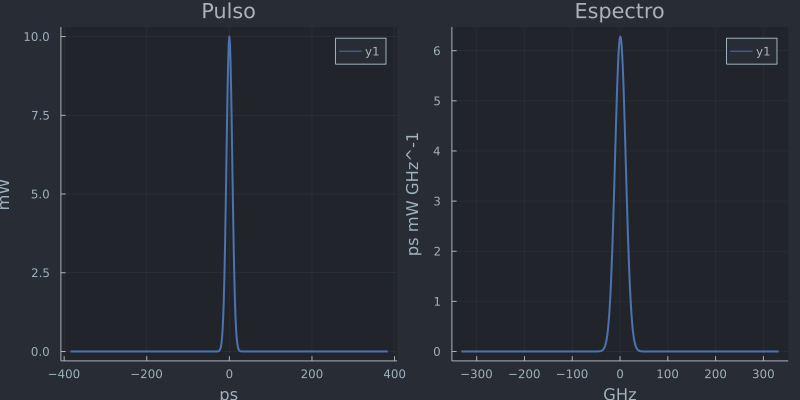

In [236]:
ϕmax = NZ_DSF.γ*100u"mW"*z[end]
Bf = sqrt(1+4/(3*sqrt(3))*ϕmax)*B0

f = range(-6*Bf, 6*Bf, N)

Δt = 1/(f[2]-f[1]) |> u"ps"
t = fftfreq(N, Δt) |> fftshift;

At0 = sqrt(P0)*exp.(-t.^2/(2T0^2))
Af0 = ufft(At0) |> fftshift
Af0 = normalize(t, At0, f, Af0)

p1 = plot(t, At0.^2, title="Pulso")
p2 = plot(f, abs.(Af0).^2, title="Espectro")
plot(p1, p2) |> display

Nuevamente definimos una grilla de coordenadas discretas $(i,\, j)$ en donde vamos a evaluar el problema. Esta grilla se va a usar tanto para indexar coordenadas $(z,\, t)$ como $(z,\, f)$.

In [237]:
ENV["LINES"]=12
ij = Iterators.product(1:N, 1:N) |> collect

512×512 Matrix{Tuple{Int64, Int64}}:
 (1, 1)    (1, 2)    (1, 3)    …  (1, 510)    (1, 511)    (1, 512)
 (2, 1)    (2, 2)    (2, 3)       (2, 510)    (2, 511)    (2, 512)
 (3, 1)    (3, 2)    (3, 3)       (3, 510)    (3, 511)    (3, 512)
 (4, 1)    (4, 2)    (4, 3)       (4, 510)    (4, 511)    (4, 512)
 ⋮                             ⋱              ⋮           
 (510, 1)  (510, 2)  (510, 3)     (510, 510)  (510, 511)  (510, 512)
 (511, 1)  (511, 2)  (511, 3)  …  (511, 510)  (511, 511)  (511, 512)
 (512, 1)  (512, 2)  (512, 3)     (512, 510)  (512, 511)  (512, 512)

### Automodulación de Fase sin Atenuación 

Para para calcular la evolución del espectro a lo largo de la fibra, usamos el resultado  
$$A(z,t) = A(0, t) \exp\left[i\gamma \lvert A(z,0)\rvert^2z\right] \longrightarrow A_t[i, j] = A_{t0}[j]\exp\left[i\gamma \lvert A_{t0}[j]\rvert^2z_i\right]$$

In [238]:
A((i, j)) = At0[j]*exp(im*fibra.γ*abs(At0[j])^2*z[i])

A (generic function with 1 method)

Evaluamos $A_t[i,j]$ en los puntos $(i,\, j) \leftrightarrow(z,\, t)$. Transformamos Fourier a lo largo de la dimensión $j$ para obtener el resultado $A_f[i,j]$ en el dominio $(i,\, j) \leftrightarrow(z,\, f)$

In [239]:
At = A.(ij)
Af = ufft(At, 2)
Af = fftshift(Af, 2)

Af = hcat([normalize(t, At, f, Af) for (Af, At) in zip(eachrow(Af), eachrow(At))]...)';

Visualizamos la evolución de la forma del pulso y del espectro en forma _heatmap_

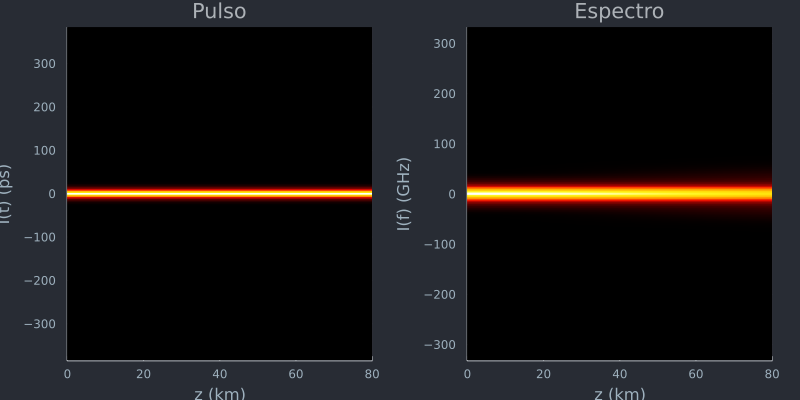

In [240]:
function heatmap_pulse(z, t, At, f, Af)
    p1 = heatmap(z, t, abs.(At').^2, xlabel="z", ylabel="I(t)", title="Pulso")
    p2 = heatmap(z, f, abs.(Af').^2, xlabel="z", ylabel="I(f)", title="Espectro")
    plot(p1, p2, layout=(1,2), colorbar=false, zaxis=:log) |> display
end

heatmap_pulse(z, t, At, f, Af)

Y también con una animación que muestra la forma del pulso mientras este se propaga a través de la fibra, y tomas instantáneas de esa animación

┌ Info: Saved animation to 
│   fn = /tmp/jl_gkvx6Y.gif
└ @ Plots /home/inox/.julia/packages/Plots/1KWPG/src/animation.jl:114


Plots.AnimatedGif("/tmp/jl_gkvx6Y.gif")
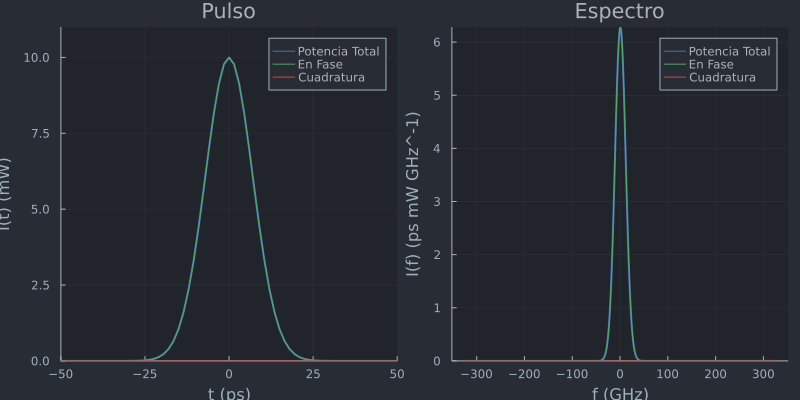

In [241]:
function animate_pulse(t, At, f, Af)
    ylimsf = (0*unit(Af[1])^2, maximum(abs.(Af).^2))
    ylimst = (0*unit(At[1])^2, maximum(abs.(At).^2)).*1.1
    xlimst = (-5*T0, 5*T0)

    @gif for i in 1:N   
        p2 = plot(f, abs.(Af[i,:]).^2, linewidth=2, ylims=ylimsf, label="Potencia Total", xlabel = "f", ylabel = "I(f)", title="Espectro")
        plot!(f, real(Af[i,:]).^2, label="En Fase", linewidth=1); 
        plot!(f, imag(Af[i,:]).^2, label="Cuadratura", linewidth=1)

        p1 = plot(t, abs.(At[i,:]).^2, linewidth=2, xlims=xlimst, ylims=ylimst, label="Potencia Total", xlabel = "t", ylabel = "I(t)", title="Pulso")
        plot!(t, real(At[i,:]).^2, label="En Fase", linewidth=1); 
        plot!(t, imag(At[i,:]).^2, label="Cuadratura", linewidth=1)
        plot(p1, p2, layout=(1,2))
    end every 8
end

animate_pulse(t, At, f, Af)

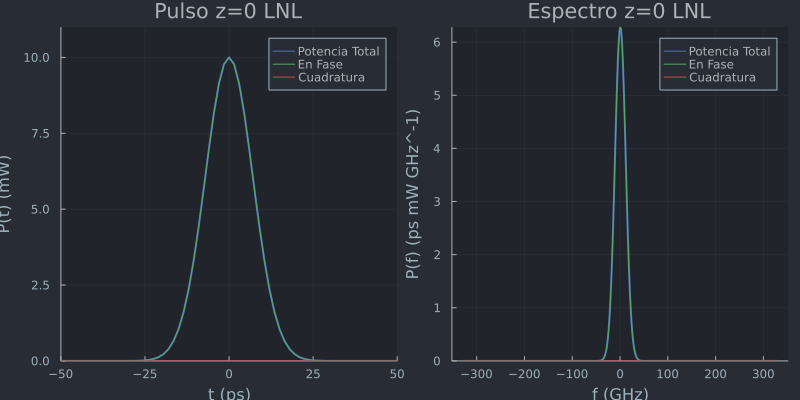

In [242]:
function plot1(n, L, label)
    xlimst = (-5*T0, 5*T0)
    ylimsf = (0*unit(Af[1])^2, maximum(abs.(Af).^2))
    ylimst = (0*unit(At[1])^2, maximum(abs.(At).^2)).*1.1
    
    i=N/n |> ceil |> Int
    zi = z[i]/L |> ceil |> Int
    p1 = plot(t, abs.(At[i,:]).^2, ylims=ylimst, xlims=xlimst, label="Potencia Total", xlabel="t", ylabel="P(t)", title="Pulso z=$zi $label")
    plot!(p1, t, real(At[i,:]).^2, label="En Fase", linewidth=1); 
    plot!(p1, t, imag(At[i,:]).^2, label="Cuadratura", linewidth=1) 

    p2 = plot(f, abs.(Af[i,:]).^2, ylims=ylimsf, label="Potencia Total", xlabel = "f", ylabel="P(f)", title="Espectro z=$zi $label")
    plot!(p2, f, real(Af[i,:]).^2, label="En Fase", linewidth=1); 
    plot!(p2, f, imag(Af[i,:]).^2, label="Cuadratura", linewidth=1)

    plot(p1, p2, layout=(1,2))
end
plot1(N, LNL, "LNL")

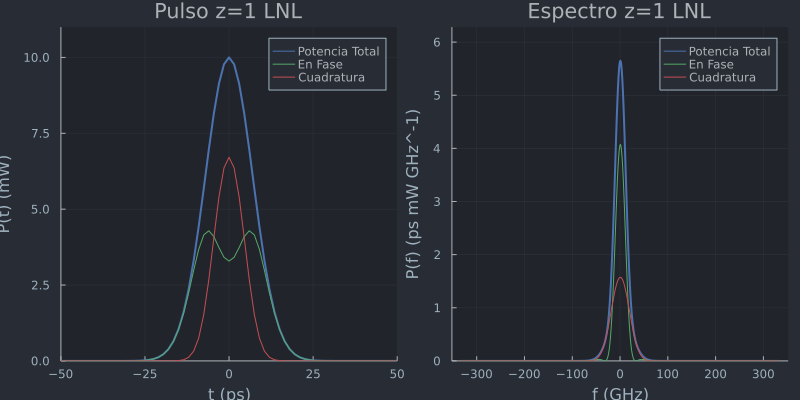

In [243]:
plot1(1, LNL, "LNL")

### Automodulación de Fase con Atenuación

Ahora consideramos el efecto de la atenuación, usamos el resultado

$$A(z,t) = A(0, t) \exp\left[i\gamma \lvert A(z,0)\rvert^2z_{eff}\right] \longrightarrow A_t[i, j] = A_{t0}[j]\exp\left[i\gamma \lvert A_{t0}[j]\rvert^2z_{eff}[i]\right]$$
Donde la longitud efectiva es: $z_{eff} = \dfrac{1-e^{-\alpha z}} \alpha$

In [244]:
function A_att((i, j))
    zeff = (1-exp(-fibra.α*z[i]))/fibra.α
    return At0[j]*exp(im*fibra.γ*abs(At0[j])^2*zeff)
end

A_att (generic function with 1 method)

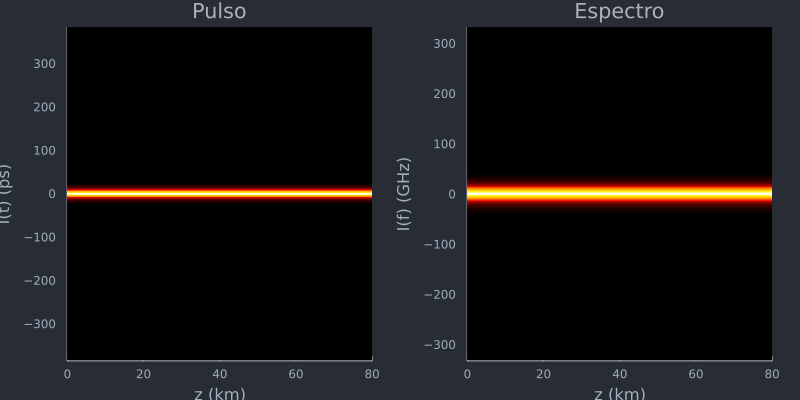

In [245]:
At = A_att.(ij)
Af = ufft(At, 2)
Af = fftshift(Af, 2)
Af = hcat([normalize(t, At, f, Af) for (Af, At) in zip(eachrow(Af), eachrow(At))]...)'

heatmap_pulse(z, t, At, f, Af)

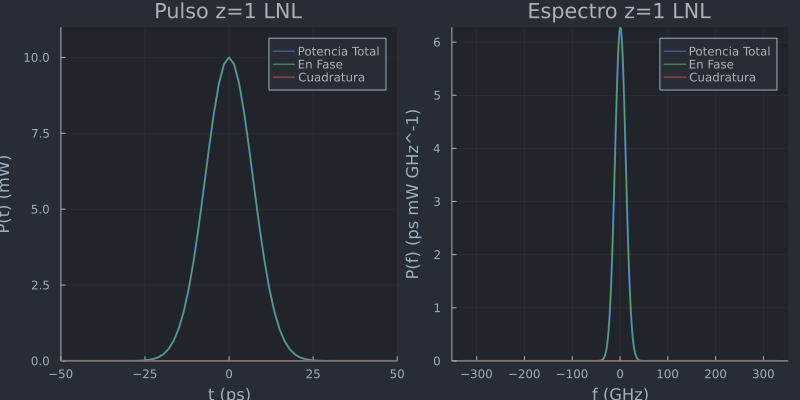

In [246]:
plot1(1, LNL, "LNL")

### Efecto de incrementar potencia del pulso

Repetimos el análisis incrementando la potencia del pulso a $100\, \text{mW}$

In [247]:
fibra = SMF
P0 = 100u"mW"
At0 = sqrt(P0)*exp.(-t.^2/(2T0^2))

Leff = 1/fibra.α
LNL = 1/(fibra.γ*P0) |> u"km"

println("Longitud característica de atenuación = $Leff\nLongitud característica de no-lineal. = $LNL")

Longitud característica de atenuación = 0.9954054173515269 km
Longitud característica de no-lineal. = 8.333333333333334 km


Primero sin atenuación:

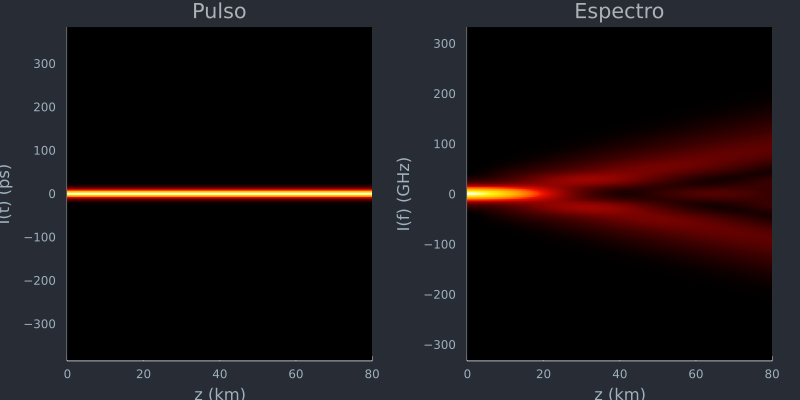

In [248]:
At = A.(ij)
Af = ufft(At, 2)
Af = fftshift(Af, 2)
Af = hcat([normalize(t, At, f, Af) for (Af, At) in zip(eachrow(Af), eachrow(At))]...)'

heatmap_pulse(z, t, At, f, Af)

┌ Info: Saved animation to 
│   fn = /tmp/jl_VDN1dd.gif
└ @ Plots /home/inox/.julia/packages/Plots/1KWPG/src/animation.jl:114


Plots.AnimatedGif("/tmp/jl_VDN1dd.gif")
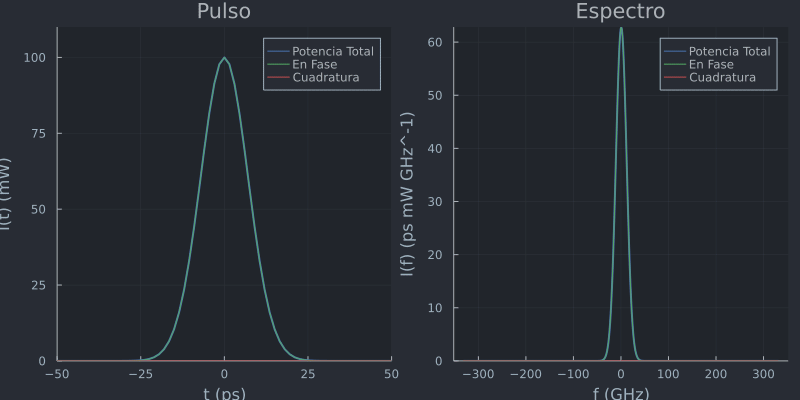

In [249]:
animate_pulse(t, At, f, Af)

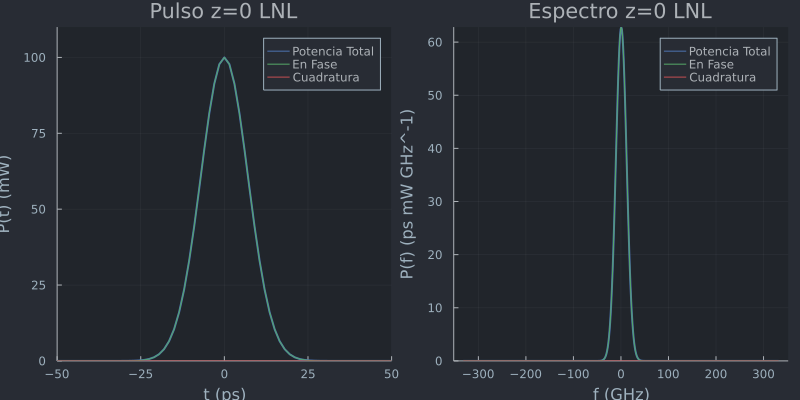

In [250]:
plot1(N, LNL, "LNL")

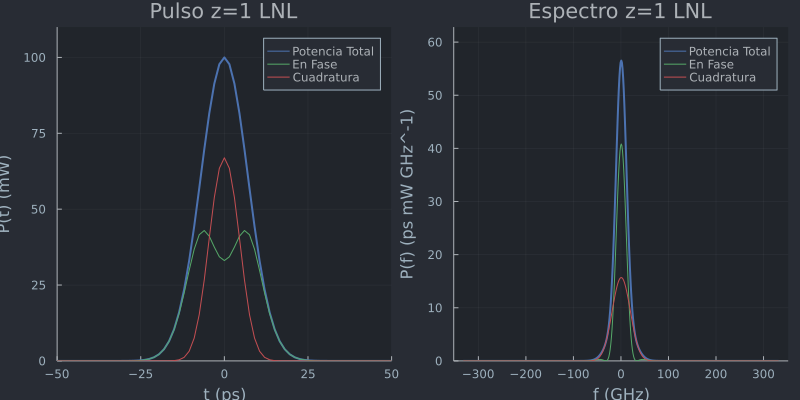

In [251]:
plot1(10, LNL, "LNL")

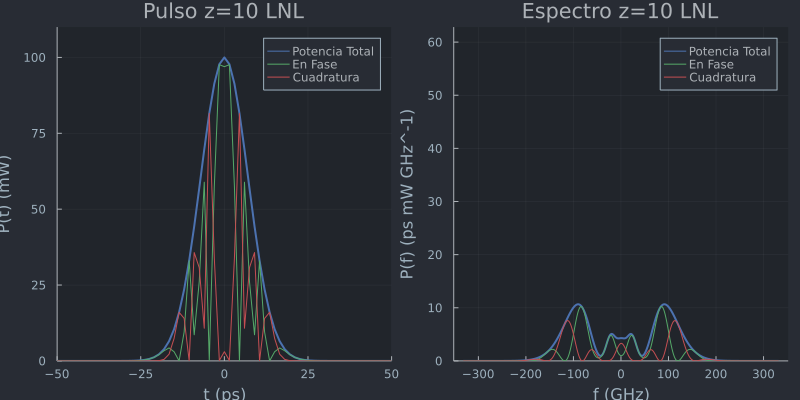

In [252]:
plot1(1, LNL, "LNL")

Ya que en este ejemplo se puede apreciar visualmente el ensanchamiento del espectro, podemos medir el número de máximos y comparar el valor medido con la aproximación teórica

$$M \simeq \frac {\phi_{max}} \pi + \frac 1 2 \qquad \qquad \phi_{max}=\gamma P_0 z_{eff}$$

El número de máximos de la simulación numérica se calcula importando la librería `Peaks` provista por el lenguaje, notar que el resultado analítico es solo una aproximación, no se espera una correspondencia exacta con la simulación numérica

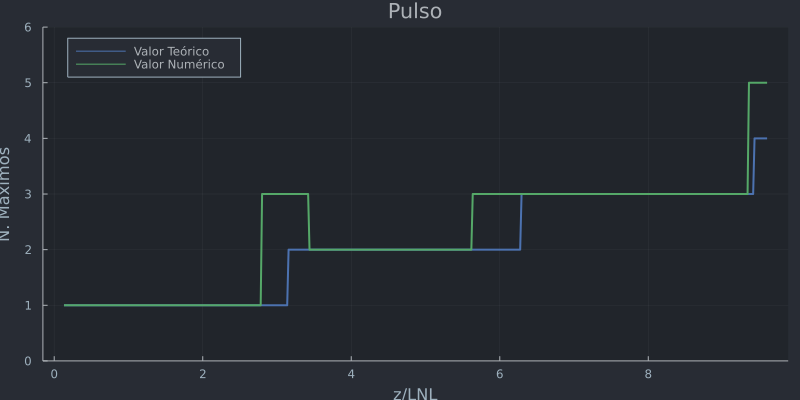

In [253]:
M(z) = fibra.γ*P0*z/π+1/2 |> round

peaks = [length(argmaxima(ustrip(abs.(A).^2))) for A in eachrow(Af)]

p1 = plot(z[8:end]/LNL, M.(z)[8:end], ylim=(0,6), xlabel="z/LNL", ylabel="N. Máximos", title="Pulso"; label="Valor Teórico", legend=:topleft)
plot!(p1, z[8:end]/LNL, peaks[8:end], label="Valor Numérico")
display(p1)

Luego con atenuación:

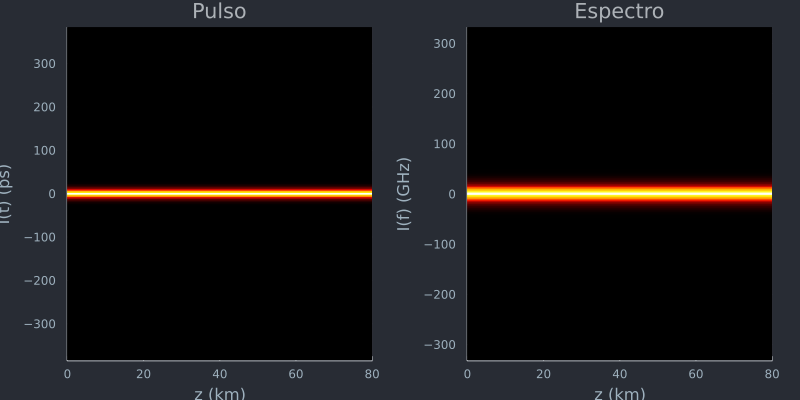

In [254]:
At = A_att.(ij)
Af = ufft(At, 2)
Af = fftshift(Af, 2)
Af = hcat([normalize(t, At, f, Af) for (Af, At) in zip(eachrow(Af), eachrow(At))]...)'

heatmap_pulse(z, t, At, f, Af)

### Fibra TW-RS

Ahora simulamos la propagación del pulso con la fibra TW-RS, primero con un pulso de $10\,\text{mW}$, sin atenuación

In [255]:
fibra = NZ_DSF
P0 = 10u"mW"
At0 = sqrt(P0)*exp.(-t.^2/(2T0^2))

Leff = 1/fibra.α
LNL = 1/(fibra.γ*P0) |> u"km"

println("Longitud característica de atenuación = $Leff\nLongitud característica de no-lineal. = $LNL")

Longitud característica de atenuación = 0.9506047936562816 km
Longitud característica de no-lineal. = 55.55555555555555 km


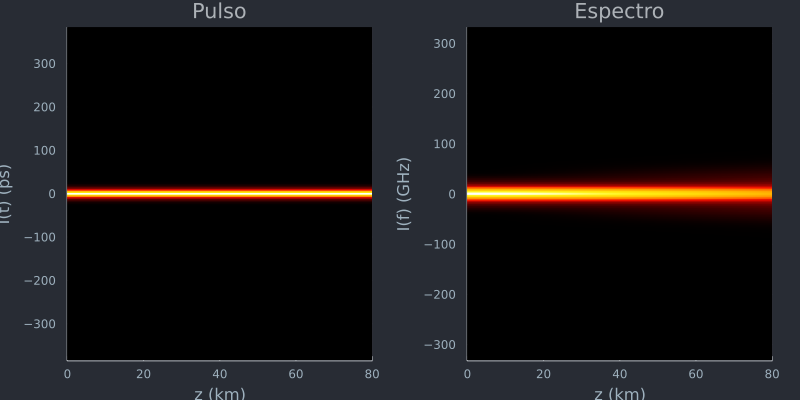

In [256]:
At = A.(ij)
Af = ufft(At, 2)
Af = fftshift(Af, 2)
Af = hcat([normalize(t, At, f, Af) for (Af, At) in zip(eachrow(Af), eachrow(At))]...)'

heatmap_pulse(z, t, At, f, Af)

┌ Info: Saved animation to 
│   fn = /tmp/jl_VvoeRm.gif
└ @ Plots /home/inox/.julia/packages/Plots/1KWPG/src/animation.jl:114


Plots.AnimatedGif("/tmp/jl_VvoeRm.gif")
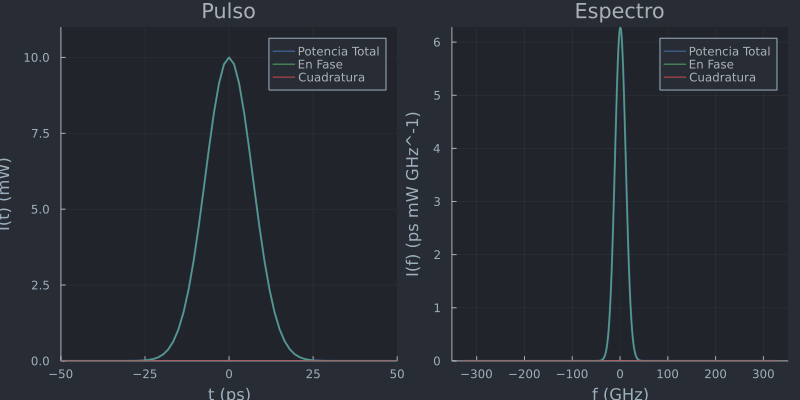

In [257]:
animate_pulse(t, At, f, Af)

Y con atenuación

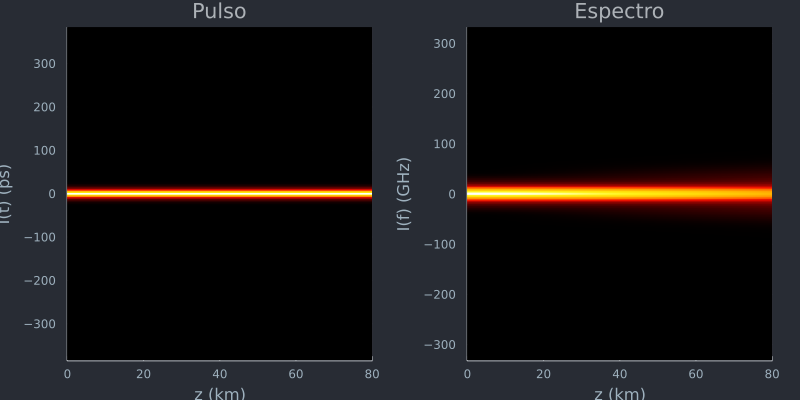

In [258]:
At = A.(ij)
Af = ufft(At, 2)
Af = fftshift(Af, 2)
Af = hcat([normalize(t, At, f, Af) for (Af, At) in zip(eachrow(Af), eachrow(At))]...)'

heatmap_pulse(z, t, At, f, Af)

Finalmente la fibra TW-RS con un pulso de $100\,\text{mW}$, sin atenuación

In [259]:
fibra = NZ_DSF
P0 = 100u"mW"
At0 = sqrt(P0)*exp.(-t.^2/(2T0^2))

Leff = 1/fibra.α
LNL = 1/(fibra.γ*P0) |> u"km"

println("Longitud característica de atenuación = $Leff\nLongitud característica de no-lineal. = $LNL")

Longitud característica de atenuación = 0.9506047936562816 km
Longitud característica de no-lineal. = 5.555555555555555 km


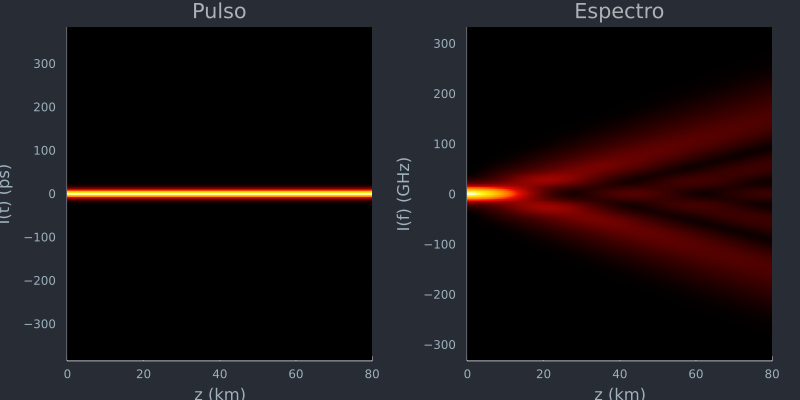

In [260]:
At = A.(ij)
Af = ufft(At, 2)
Af = fftshift(Af, 2)
Af = hcat([normalize(t, At, f, Af) for (Af, At) in zip(eachrow(Af), eachrow(At))]...)'

heatmap_pulse(z, t, At, f, Af)

┌ Info: Saved animation to 
│   fn = /tmp/jl_Oy3evu.gif
└ @ Plots /home/inox/.julia/packages/Plots/1KWPG/src/animation.jl:114


Plots.AnimatedGif("/tmp/jl_Oy3evu.gif")
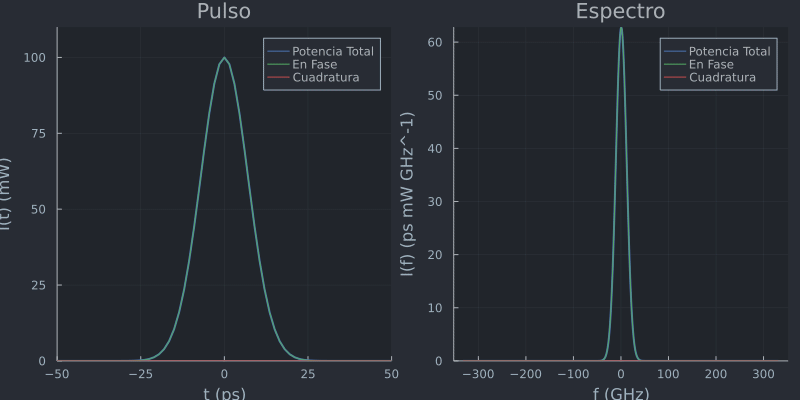

In [261]:
animate_pulse(t, At, f, Af)

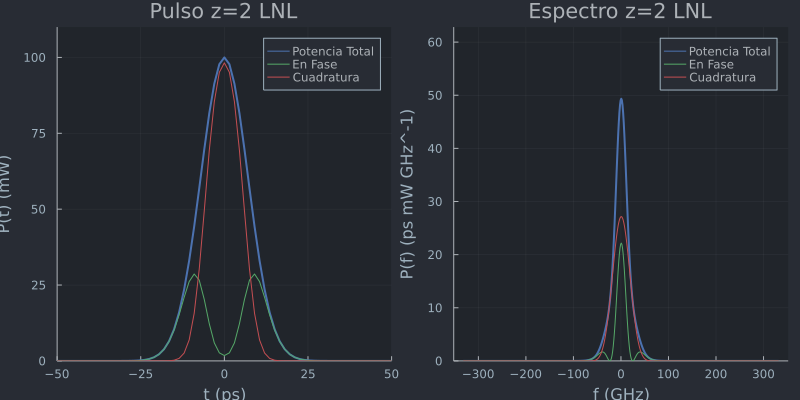

In [262]:
plot1(10, LNL, "LNL")

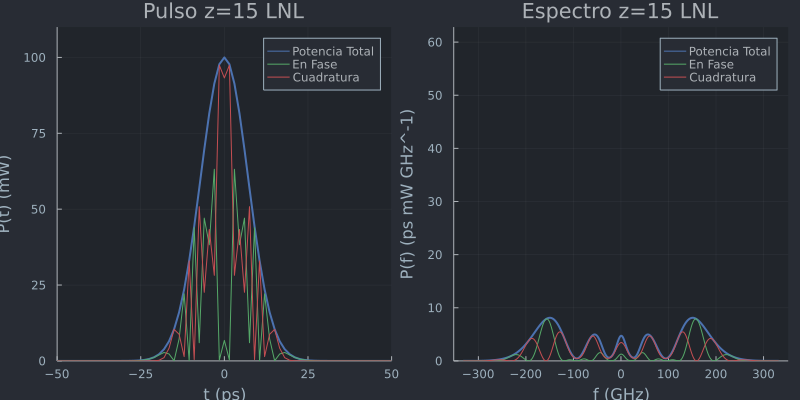

In [263]:
plot1(1, LNL, "LNL")

Vemos nuevamente el incremento de máximos en el espectro

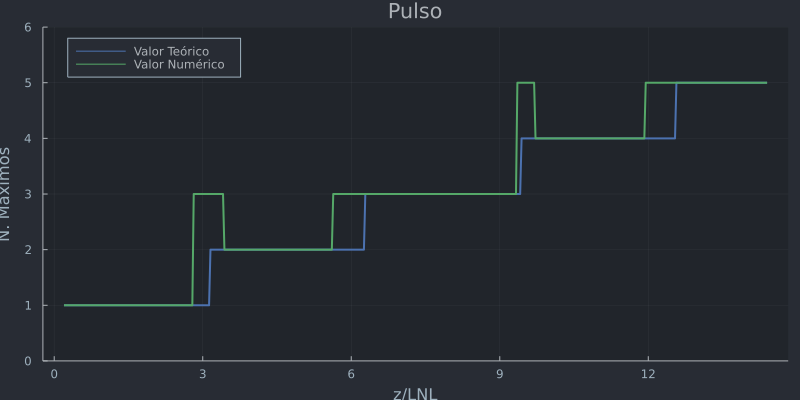

In [264]:
M(z) = fibra.γ*P0*z/π+1/2 |> round

peaks = [length(argmaxima(ustrip(abs.(A).^2))) for A in eachrow(Af)]

p1 = plot(z[8:end]/LNL, M.(z)[8:end], ylim=(0,6), xlabel="z/LNL", ylabel="N. Máximos", title="Pulso"; label="Valor Teórico", legend=:topleft)
plot!(p1, z[8:end]/LNL, peaks[8:end], label="Valor Numérico")
display(p1)

Y con atenuación

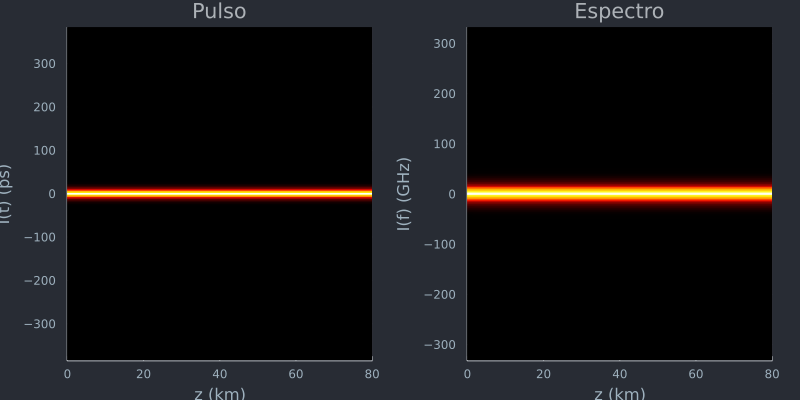

In [265]:
At = A_att.(ij)
Af = ufft(At, 2)
Af = fftshift(Af, 2);
Af = hcat([normalize(t, At, f, Af) for (Af, At) in zip(eachrow(Af), eachrow(At))]...)'

heatmap_pulse(z, t, At, f, Af)

En todos los casos se ve que la atenuación efectivamente mata a la SPM muy rápidamente, para estos valores de $\alpha$ y $\gamma$